In [46]:
# Imports (External)
import sys
sys.path.append('../') 

import numpy as np
import pandas as pd
import datetime as dt
import xlrd
import xlsxwriter
from collections import OrderedDict
import copy
 
# Visualization/plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt

# Preprocessing/Scaling/Feature Imports
import pywt
from pywt import wavedec, waverec
from scipy import signal
from statsmodels.robust import mad
from sklearn import preprocessing


# Machine Learning/Deep Learning Imports
import sklearn
import tensorflow as tf
import keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import optimizers
from keras import regularizers

# Internal Imports
from src.utils import pickle_load,pickle_save
from src.models.wavelet import waveletSmooth

In [47]:
dict_dataframes_index=pickle_load(path_filename="../data/interim/cdii_tvt_split.pickle")
ddi_scaled=pickle_load(path_filename="../data/interim/cdii_tvt_split_scaled.pickle")
ddi_denoised=pickle_load(path_filename="../data/interim/cdii_tvt_split_scaled_denoised.pickle")

In [61]:
dict_dataframes_index.keys()

dict_keys(['csi300 index data', 'nifty 50 index data', 'hangseng index data', 'nikkei 225 index data', 's&p500 index data', 'djia index data'])

In [62]:
# Train
#dict_dataframes_index['csi300 index data'][1][1].head(2)

In [63]:
# Test
#dict_dataframes_index['csi300 index data'][1][3].head(2)

In [64]:
# Validate
#dict_dataframes_index['csi300 index data'][1][2].head(2)

In [108]:
# Multi-level wavelet transform

#https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html
#https://pywavelets.readthedocs.io/en/latest/ref/thresholding-functions.html
#https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#ref-modes

def waveletSmooth( x, wavelet="haar", level=2, declevel=2):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode='periodization',level=declevel,axis=0 )
    # calculate a threshold
    sigma = mad(coeff[-level])
    #print("sigma: ",sigma)
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    #print("uthresh: ", uthresh)
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="hard" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode='periodization',axis=0 )
    return y

In [109]:

scaler = preprocessing.RobustScaler()

X_train = dict_dataframes_index['csi300 index data'][1][1]
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled,columns=list(X_train.columns))

# X_val = dict_dataframes_index['csi300 index data'][1][2]
# X_val_scaled = scaler.transform(X_val)
# X_val_scaled_df = pd.DataFrame(X_val_scaled,columns=list(X_val.columns))

# X_test = dict_dataframes_index['csi300 index data'][1][3]
# X_test_scaled = scaler.transform(X_test)
# X_test_scaled_df = pd.DataFrame(X_test_scaled,columns=list(X_test.columns))

# Wavelet Denoise
X_train_scaled_denoised_df = pd.DataFrame(waveletSmooth(X_train_scaled))      
# X_val_scaled_denoised_df = pd.DataFrame(waveletSmooth(X_val_scaled),columns=list(X_val_scaled.columns))  
# X_test_scaled_denoised_df = pd.DataFrame(waveletSmooth(X_test_scaled),columns=list(X_test_scaled.columns))     

In [110]:
print(dict_dataframes_index['csi300 index data'][1][1].columns)
print(len(dict_dataframes_index['csi300 index data'][1][1]))
print(len(dict_dataframes_index['csi300 index data'][1][1].columns))
print(dict_dataframes_index['csi300 index data'][1][1].shape[1])

Index(['open', 'high', 'low', 'close', 'volume', 'us dollar index', 'shibor',
       'macd', 'cci', 'atr', 'boll', 'ema20', 'ma10', 'mtm6', 'ma5', 'mtm12',
       'roc', 'smi', 'wvad'],
      dtype='object')
489
19
19


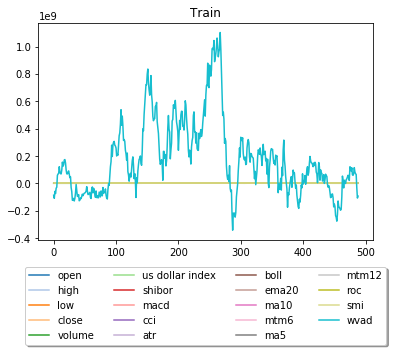

In [111]:
# Train
# plt.plot(X_train.values);

f, ax = plt.subplots()
plt.title("Train")
colormap = plt.cm.tab20
colors = [colormap(i) for i in np.linspace(0, 1,20)]
ax.set_prop_cycle('color', colors)
ax.plot(X_train.values)
plt.legend(X_train.columns,loc='upper center',bbox_to_anchor=(0.5, -0.1),
           ncol=4,fancybox=True,shadow=True)
plt.show()

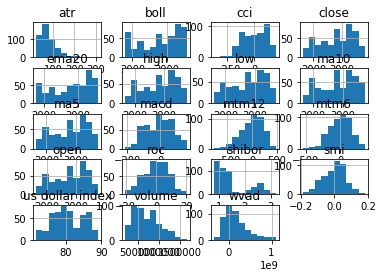

In [112]:
X_train.hist();

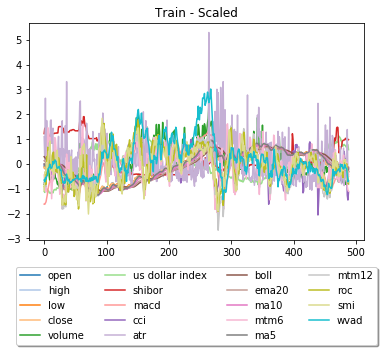

In [113]:
# Train, Scaled
# plt.plot(X_train_scaled_df.values);
f, ax = plt.subplots()
plt.title("Train - Scaled")
colormap = plt.cm.tab20
colors = [colormap(i) for i in np.linspace(0, 1,20)]
ax.set_prop_cycle('color', colors)
ax.plot(X_train_scaled_df.values)
plt.legend(X_train.columns,loc='upper center',bbox_to_anchor=(0.5, -0.1),
           ncol=4,fancybox=True,shadow=True)
plt.show()

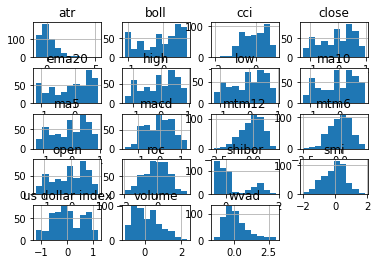

In [114]:
X_train_scaled_df.hist();

In [115]:
# Train, Scaled & Denoised Dataframe (Level parameter/Axis examination)
X_train_scaled_denoised_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.128562,-0.111557,-0.142953,-0.139088,-0.681506,-1.088820,1.198424,-1.588195,-0.694604,0.965162,0.239430,0.086047,-0.046230,-0.826665,-0.067377,-0.795497,-0.726688,-0.503996,-0.640189
1,-0.128562,-0.111557,-0.142953,-0.139088,-0.681506,-1.088820,1.416969,-1.588195,-0.694604,0.965162,0.239430,0.086047,-0.046230,-0.826665,-0.067377,-0.795497,-0.726688,-0.503996,-0.640189
2,-0.128562,-0.111557,-0.142953,-0.139088,-0.681506,-1.088820,1.307696,-1.588195,-0.694604,0.965162,0.239430,0.086047,-0.046230,-0.826665,-0.067377,-0.795497,-0.726688,-0.503996,-0.640189
3,-0.128562,-0.111557,-0.142953,-0.139088,-0.681506,-1.088820,1.307696,-1.588195,-0.694604,0.965162,0.239430,0.086047,-0.046230,-0.826665,-0.067377,-0.795497,-0.726688,-0.503996,-0.640189
4,0.036466,0.085393,0.053873,0.085988,-0.128908,-1.055213,1.252081,-1.146143,0.429276,1.041494,0.123312,0.042966,-0.047133,0.872876,-0.020848,0.362417,0.344721,0.083817,-0.336795


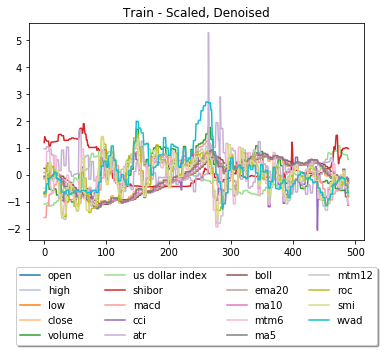

In [116]:
# Train, Scaled & Denoised
# plt.plot(X_train_scaled_denoised_df.values);
f, ax = plt.subplots()
plt.title("Train - Scaled, Denoised")
colormap = plt.cm.tab20
colors = [colormap(i) for i in np.linspace(0, 1,20)]
ax.set_prop_cycle('color', colors)
ax.plot(X_train_scaled_denoised_df.values)
plt.legend(X_train.columns,loc='upper center',bbox_to_anchor=(0.5, -0.1),
           ncol=4,fancybox=True,shadow=True)
plt.show()

In [117]:
# Test inverse_transform to reverse scaling
#plt.plot(scaler.inverse_transform(X_train_scaled_df));